The script is used to evaluate the error of PCE-----Created on 2021/05/12 by Qian Wang

In [33]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib import rc
# import latex
rc("text", usetex=False)

from basic.read_data import read_specify, file_settings
from basic.utils import dist_return

In [38]:
# Import settings of PCE
from error_fixing import fix_group_ranking
input_path = file_settings()[1]
output_path = file_settings()[0]
output_path = '../test_func/output/'
samples, values = read_specify('model', 'reduced', 
    product_uniform=False, num_vars=11)
samples_22, _ = read_specify('model', 'full', 
    product_uniform=False, num_vars=22)
values_vali = values[1000:]
samples_vali = samples[:, 1000:]
samples_22_vali = samples_22[:, 1000:]

In [14]:
samples_22_vali.shape

(7, 9000)

In [39]:
# Calculate the error (RMSE) of PCE
product_uniform = ['exact', 'uniform', False] #, 'uniform'
rmse_all = {}
for p in product_uniform:
    dist_type = dist_return(p)
    filename = f'adaptive-reduce-{dist_type}_552'
    print(filename)
    approx_list_all = pickle.load(open(f'{output_path}{filename}-approx-list.pkl', "rb"))
    rmse_exact = pd.DataFrame(columns = np.arange(10, 1000, 50), index=np.arange(0, 100, 1))

    for key, value in approx_list_all.items():
        rmse_temp = []
        nsample = int(key.split('_')[1])
        if (nsample >= 10) and (nsample <= 1000):
            for pce in value:
                if dist_type == 'full':
                    y_hat = pce(samples_22_vali)
                else:
                    y_hat = pce(samples_vali)
                rmse_abs = (((y_hat.flatten()-values_vali.flatten())**2).mean())**0.5
                rmse_temp.append(rmse_abs / values_vali.std())
            rmse_exact.loc[0:(len(rmse_temp)-1), nsample] = rmse_temp
#     rmse_exact = pd.DataFrame.from_dict(rmse_exact)
    rmse_all[dist_type] = rmse_exact.mean(axis=0)
    rmse_all[dist_type + '_min'] = rmse_exact.min(axis=0)
    rmse_all[dist_type + '_max'] = rmse_exact.max(axis=0)

adaptive-reduce-exact_552
adaptive-reduce-uniform_552
adaptive-reduce-full_552


In [40]:
df = pd.DataFrame.from_dict(rmse_all).dropna()
df = df.reset_index()
df.head(5)

,index,exact,exact_min,exact_max,uniform,uniform_min,uniform_max,full,full_min,full_max
0,10,0.667241,0.529064,0.864744,0.480049,0.470808,0.491886,1.159250,1.155168,1.164513
1,60,0.238714,0.233015,0.254005,0.237882,0.231718,0.248081,0.354839,0.328595,0.387641
2,110,0.291584,0.168068,0.624831,0.235564,0.184313,0.342308,0.469073,0.363226,0.502679
3,160,0.568098,0.437370,0.663071,0.678898,0.386586,1.187311,0.567302,0.531790,0.638981
4,210,0.650948,0.599165,0.719055,0.793856,0.596191,1.005767,0.479461,0.415587,0.642638


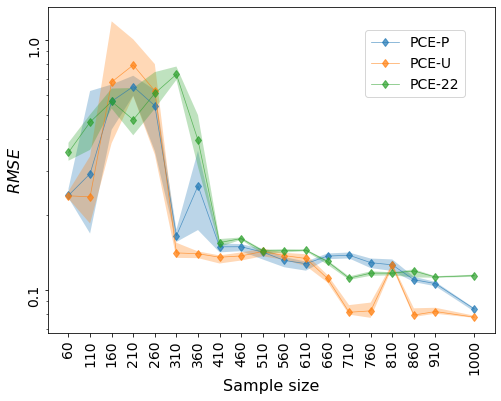

In [41]:
# Plot RMSE vs sample size
import matplotlib.ticker as mticker
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 6))
index_plot = np.array(np.arange(1, df.shape[0], 1))
xticks = [i for i in df['index'].values[index_plot]]
ax1 = df.iloc[index_plot].plot(x='index', y=df.columns[[1, 4, 7]], kind='line', marker='d',
                legend=True, logy=True, xticks=xticks, ax=axes, linewidth=0.7, alpha=0.7)
for k in range(3):
    ax1.fill_between(ax1.get_xticks(), df.iloc[index_plot][df.columns[3*k + 2]].values, df.iloc[index_plot][df.columns[3*k + 3]].values, alpha=0.3)
ax1.legend(['PCE-P', 'PCE-U', 'PCE-22'], bbox_to_anchor=(0.95, 0.95), fontsize=14) # 'PCE-U',
ax1.set_ylabel(r'$RMSE$', fontsize = 16);
ax1.set_xlabel('Sample size', fontsize = 16);
# ax1.set_ylim(0.0, 0.001)
ax1.set_xticklabels(xticks, rotation=90, fontsize=14);
ticks_loc = ax1.get_yticks().tolist()
ax1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax1.set_yticklabels(ax1.get_yticks(), rotation=90, fontsize=14);
# plt.savefig(f'{output_path}/figure/adaptive_independent_validation_log.png', dpi=300, format='png')

# generate the 1-1 scatter plot

In [19]:
# Calculate the error (RMSE) of PCE
product_uniform = ['exact', 'uniform', False] # 'uniform', 
rmse_all = {}
for p in product_uniform:
    dist_type = dist_return(p)
    filename = f'adaptive-reduce-{dist_type}_552'
    approx_list_all = pickle.load(open(f'{output_path}{filename}-approx-list.pkl', "rb"))
    
    for key, value in approx_list_all.items():
        if int(key.split('_')[1]) in [50, 150, 250, 350, 450]:
            rmse_exact = {}
            for ii in range(len(value)):
                pce = value[ii]
                if dist_type == 'full':
                    y_hat = pce(samples_22_vali)
                else:
                    y_hat = pce(samples_vali)
                
                rmse_exact[ii] = y_hat.flatten()
                
            rmse_all[f'{dist_type}{key}'] = pd.DataFrame.from_dict(rmse_exact).mean(axis=1).values

In [20]:
# Scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
# import latex
rc("text", usetex=False)

Text(0, 0.5, '$\\hat y$')

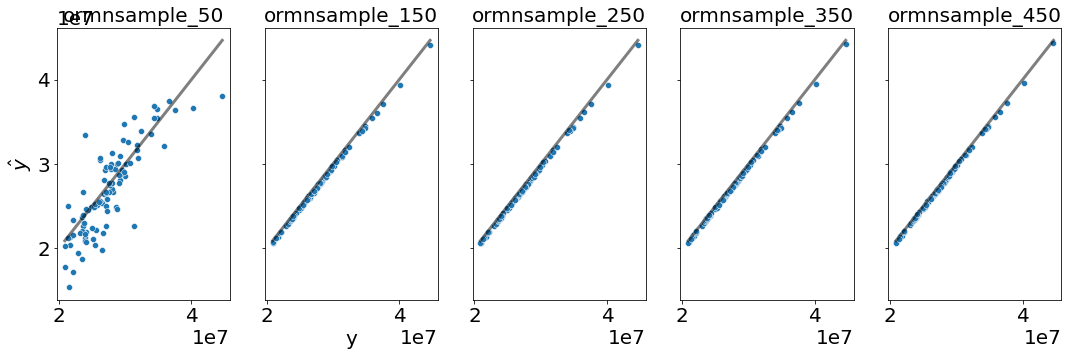

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18,5))
k = 0; dist_type = 'uniform' 
for key, y_hat in rmse_all.items():
    if dist_type in key:
        sns.scatterplot(x=values_vali.flatten(), y = y_hat, ax=axes[k])
        sns.lineplot(x=values_vali.flatten(), y=values_vali.flatten(), ax=axes[k], color='k', alpha=0.5)
        axes[k].set_title(key[4:])
        k += 1
axes[1].set_xlabel('y')
axes[0].set_ylabel(r'$\hat y$')
# plt.savefig(f'../output/adaptive/figure/pce_scatter_{dist_type}_data.png', dpi=300, format='png')

In [20]:
values.shape

(1024, 1)